# Basics

# Self-Supervised Learning 

## What is self-supervised learning?
Modern day machine learning requires lots of labeled data. But often times it's challenging and/or expensive to obtain large amounts of human-labeled data. Is there a way we could ask machines to automatically learn a model which can generate good visual representations without a labeled dataset? Yes, enter self-supervised learning! 

Self-supervised learning (SSL) allows models to automatically learn a "good" representation space using the data in a given dataset without the need for their labels. Specifically, if our dataset were a bunch of images, then self-supervised learning allows a model to learn and generate a "good" representation vector for images. 

The reason SSL methods have seen a surge in popularity is because the learnt model continues to perform well on other datasets as well i.e. new datasets on which the model was not trained on!

## What makes a "good" representation?
A "good" representation vector needs to capture the important features of the image as it relates to the rest of the dataset. This means that images in the dataset representing semantically similar entities should have similar representation vectors, and different  images in the dataset should have different representation vectors. For example, two images of an apple should have similar representation vectors, while an image of an apple and an image of a banana should have different representation vectors.

## Contrastive Learning: SimCLR
Recently, [SimCLR](https://arxiv.org/pdf/2002.05709.pdf) introduces a new architecture which uses **contrastive learning** to learn good visual representations. Contrastive learning aims to learn similar representations for similar images and different representations for different images. As we will see in this notebook, this simple idea allows us to train a surprisingly good model without using any labels.

Specifically, for each image in the dataset, SimCLR generates two differently augmented views of that image, called a **positive pair**. Then, the model is encouraged to generate similar representation vectors for this pair of images. See below for an illustration of the architecture (Figure 2 from the paper).

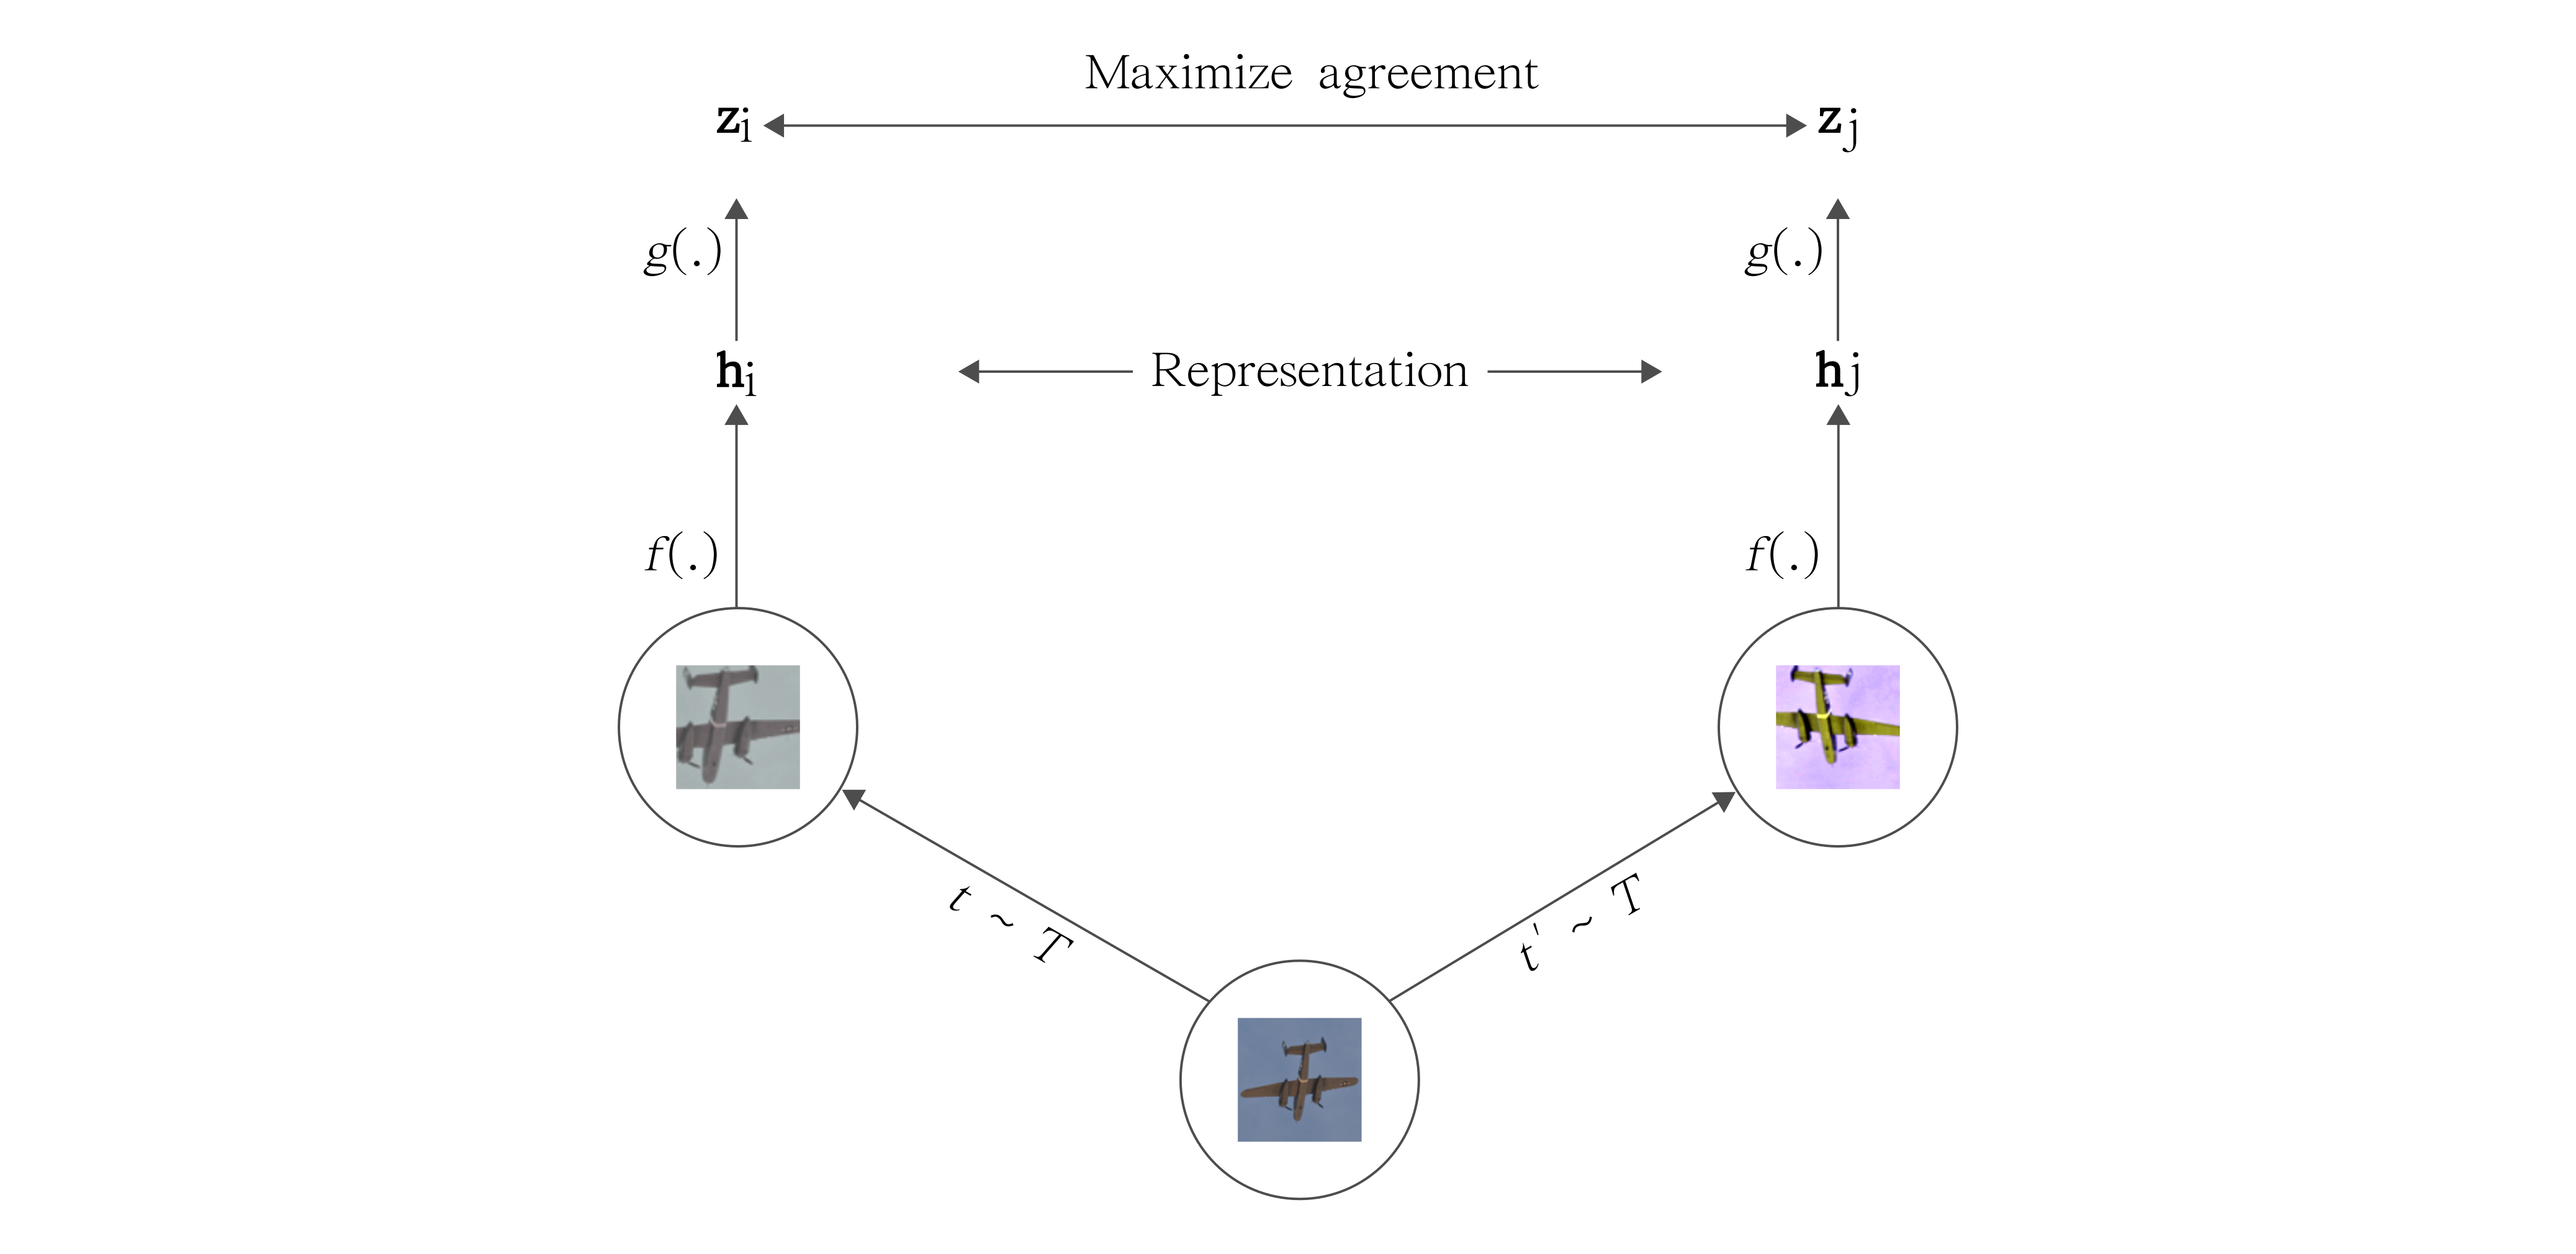

In [44]:
import numpy as np
from IPython.display import Image

Image("https://sthalles.github.io/assets/contrastive-self-supervised/cover.png")

Given an image **x**, SimCLR uses two different data augmentation schemes **t** and **t'** to generate the positive pair of images **$\hat{x}_i$** and **$\hat{x}_j$**. $f$ is a basic encoder net that  extracts representation vectors from the augmented data samples, which yields **$h_i$** and **$h_j$**, respectively. Finally, a small neural network projection head $g$ maps the representation vectors to the space where the contrastive loss is applied. The goal of the contrastive loss is to maximize agreement between the final vectors **$z_i = g(h_i)$** and **$z_j = g(h_j)$**. We will discuss the contrastive loss in more detail later, and you will get to implement it.

After training is completed, we throw away the projection head $g$ and only use $f$ and the representation $h$ to perform downstream tasks, such as classification. You will get a chance to finetune a layer on top of a trained SimCLR model for a classification task and compare its performance with a baseline model (without self-supervised learning).

## Pretrained Weights
pretrained weights (trained for ~18 hours on CIFAR-10) for the SimCLR model
in "./pretrained_model"

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Base Encoder and Projection Head
The next steps are to apply the base encoder and projection head to the augmented samples **$\hat{x}_i$** and **$\hat{x}_j$**.

The base encoder $f$ extracts representation vectors for the augmented samples. The SimCLR paper found that using deeper and wider models improved performance and thus chose [ResNet](https://arxiv.org/pdf/1512.03385.pdf) to use as the base encoder. The output of the base encoder are the representation vectors **$h_i = f(\hat{x}_i$)** and **$h_j = f(\hat{x}_j$)**.

The projection head $g$ is a small neural network that maps the representation vectors **$h_i$** and **$h_j$** to the space where the contrastive loss is applied. The paper found that using a nonlinear projection head improved the representation quality of the layer before it. Specifically, they used a MLP with one hidden layer as the projection head $g$. The contrastive loss is then computed based on the outputs **$z_i = g(h_i$)** and **$z_j = g(h_j$)**.

## SimCLR: Contrastive Loss

A mini-batch of $N$ training images yields a total of $2N$ data-augmented examples. For each positive pair $(i, j)$ of augmented examples, the contrastive loss function aims to maximize the agreement of vectors $z_i$ and $z_j$. Specifically, the loss is the normalized temperature-scaled cross entropy loss and aims to maximize the agreement of $z_i$ and $z_j$ relative to all other augmented examples in the batch:
$$
l \; (i, j) = -\log \frac{\exp (\;\text{sim}(z_i, z_j)\; / \;\tau) }{\sum_{k=1}^{2N} \mathbb{1}_{k \neq i} \exp (\;\text{sim} (z_i, z_k) \;/ \;\tau) }
$$

where $\mathbb{1} \in \{0, 1\}$ is an indicator function that outputs $1$ if $k\neq i$ and $0$ otherwise. $\tau$ is a temperature parameter that determines how fast the exponentials increase.

sim$(z_i, z_j) = \frac{z_i \cdot z_j}{|| z_i || || z_j ||}$ is the (normalized) dot product between vectors $z_i$ and $z_j$. The higher the similarity between $z_i$ and $z_j$, the larger the dot product is, and the larger the numerator becomes. The denominator normalizes the value by summing across $z_i$ and all other augmented examples $k$ in the batch. The range of the normalized value is $(0, 1)$, where a high score close to $1$ corresponds to a high similarity between the positive pair $(i, j)$ and low similarity between $i$ and other augmented examples $k$ in the batch. The negative log then maps the range $(0, 1)$ to the loss values $(\inf, 0)$. 

The total loss is computed across all positive pairs $(i, j)$ in the batch. Let $z = [z_1, z_2, ..., z_{2N}]$ include all the augmented examples in the batch, where $z_{1}...z_{N}$ are outputs of the left branch, and $z_{N+1}...z_{2N}$ are outputs of the right branch. Thus, the positive pairs are $(z_{k}, z_{k + N})$ for $\forall k \in [1, N]$. 

Then, the total loss $L$ is:

$$
L = \frac{1}{2N} \sum_{k=1}^N [ \; l(k, \;k+N) + l(k+N, \;k)\;]
$$

**NOTE:** this equation is slightly different from the one in the paper. We've rearranged the ordering of the positive pairs in the batch, so the indices are different. The rearrangement makes it easier to implement the code in vectorized form.

## Datasets

In [46]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from PIL import Image

from simclr import SimCLR, train, test, train_val
from thop import profile, clever_format

BATCH_SIZE = 64
FEATURE_DIM = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
pretrained_path = './pretrained_model/pretrained_simclr_model.pth'

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Transform
color_jitter = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4912, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4912, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])

class CIFAR10Pair(CIFAR10):
    """CIFAR10 Dataset.
    """
    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        x_i = None
        x_j = None

        if self.transform is not None:
            
            x_i = self.transform(img)
            x_j = self.transform(img)

        return x_i, x_j, label


train_data = CIFAR10Pair(root='./data', train=True, transform=train_transform, download=True)
train_data = torch.utils.data.Subset(train_data, indices=list(np.arange(int(len(train_data)*0.5))))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)
test_data = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)
memory_data = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
memory_loader = DataLoader(memory_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

model = SimCLR(FEATURE_DIM)
model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu')), strict=False)
model = model.to(device)
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPS: {}'.format(params, flops))
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE, weight_decay=WEIGHT_DECAY)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
# Model Params: 24.62M FLOPS: 1.31G


## Train

In [47]:
import os

EPOCHS = 1
K = 200
TEMPERATURE = 0.5

memory_class = len(memory_data.classes)
best_acc = 0.0
results = {'train_loss': [], 'test_acc@1': [], 'test_acc@5': []} #<< -- output
if not os.path.exists('./results'):
    os.mkdir('./results')
    
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, 
                       train_transform, epoch, EPOCHS, 
                       batch_size=BATCH_SIZE, temperature=TEMPERATURE, device=device)
    
    results['train_loss'].append(train_loss)
    test_acc_1, test_acc_5 = test(model, memory_loader, test_loader, epoch, EPOCHS, memory_class, k=K, temperature=TEMPERATURE, device=device)
    results['test_acc@1'].append(test_acc_1)
    results['test_acc@5'].append(test_acc_5)
    
    # Save statistics.
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        torch.save(model.state_dict(), './pretrained_model/trained_simclr_model.pth')

Test Epoch: [1/1] Acc@1:83.14% Acc@5:99.43%: 100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


## Finetune a Linear Layer for Classification!

Now it's time to put the representation vectors to the test!

We remove the projection head from the SimCLR model and slap on a linear layer to finetune for a simple classification task. All layers before the linear layer are frozen, and only the weights in the final linear layer are trained. We compare the performance of the SimCLR + finetuning model against a baseline model, where no self-supervised learning is done beforehand, and all weights in the model are trained. You will get to see for yourself the power of self-supervised learning and how the learned representation vectors improve downstream task performance.

## Baseline: Without Self-Supervised Learning
First, let's take a look at the baseline model. We'll remove the projection head from the SimCLR model and slap on a linear layer to finetune for a simple classification task. No self-supervised learning is done beforehand, and all weights in the model are trained. Run the following cells.

In [48]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, num_class):
        super(Classifier, self).__init__()

        # Encoder.
        self.f = SimCLR().f
        
        # Classifier.
        self.fc = nn.Linear(2048, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

In [50]:
EPOCHS = 10
percentage = 0.1
BATCH_SIZE = 128

train_data = CIFAR10(root='data', train=True, transform=train_transform, download=True)
train_set = torch.utils.data.Subset(train_data, list(np.arange(int(len(train_data)*percentage))))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

model = Classifier(num_class=len(train_data.classes)).to(device)
for param in model.f.parameters():
    param.requires_grad = False

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
no_pretrain_results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [],
           'test_loss': [], 'test_acc@1': [], 'test_acc@5': []}

best_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc_1, train_acc_5 = train_val(model, train_loader, optimizer, epoch, EPOCHS, device=device)
    no_pretrain_results['train_loss'].append(train_loss)
    no_pretrain_results['train_acc@1'].append(train_acc_1)
    no_pretrain_results['train_acc@5'].append(train_acc_5)
    test_loss, test_acc_1, test_acc_5 = train_val(model, test_loader, None, epoch, EPOCHS, device=device)
    no_pretrain_results['test_loss'].append(test_loss)
    no_pretrain_results['test_acc@1'].append(test_acc_1)
    no_pretrain_results['test_acc@5'].append(test_acc_5)
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
        
# Print the best test accuracy.
print('Best top-1 accuracy without self-supervised learning: ', best_acc)

Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
# Model Params: 23.52M FLOPs: 1.31G


Train Epoch: [1/10] Loss: 2.4773 ACC@1: 10.88% ACC@5: 51.22%: 100%|██████████| 40/40 [00:02<00:00, 16.32it/s]
Test Epoch: [1/10] Loss: 2.3152 ACC@1: 13.55% ACC@5: 52.95%: 100%|██████████| 79/79 [00:04<00:00, 19.02it/s]
Train Epoch: [2/10] Loss: 2.3670 ACC@1: 12.78% ACC@5: 53.10%: 100%|██████████| 40/40 [00:02<00:00, 16.93it/s]
Test Epoch: [2/10] Loss: 2.3945 ACC@1: 11.65% ACC@5: 56.05%: 100%|██████████| 79/79 [00:04<00:00, 19.14it/s]
Train Epoch: [3/10] Loss: 2.3937 ACC@1: 12.20% ACC@5: 54.82%: 100%|██████████| 40/40 [00:02<00:00, 16.83it/s]
Test Epoch: [3/10] Loss: 2.3110 ACC@1: 12.09% ACC@5: 59.94%: 100%|██████████| 79/79 [00:04<00:00, 19.07it/s]
Train Epoch: [4/10] Loss: 2.3592 ACC@1: 12.86% ACC@5: 56.16%: 100%|██████████| 40/40 [00:02<00:00, 16.91it/s]
Test Epoch: [4/10] Loss: 2.4202 ACC@1: 13.37% ACC@5: 56.81%: 100%|██████████| 79/79 [00:04<00:00, 19.12it/s]
Train Epoch: [5/10] Loss: 2.3928 ACC@1: 11.38% ACC@5: 56.00%: 100%|██████████| 40/40 [00:02<00:00, 16.64it/s]
Test Epoch: [5

Best top-1 accuracy without self-supervised learning:  16.34


## With Self-Supervised Learning

Let's see how much improvement we get with self-supervised learning. Here, we pretrain the SimCLR model using the simclr loss you wrote, remove the projection head from the SimCLR model, and use a linear layer to finetune for a simple classification task.

In [51]:
pretrained_path = './pretrained_model/trained_simclr_model.pth'

train_data = CIFAR10(root='data', train=True, transform=train_transform, download=True)
train_set = torch.utils.data.Subset(train_data, list(np.arange(int(len(train_data)*percentage))))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=16, pin_memory=True)

model = Classifier(num_class=len(train_data.classes))
model.load_state_dict(torch.load(pretrained_path, map_location='cpu'), strict=False)
model = model.to(device)
for param in model.f.parameters():
    param.requires_grad = False

flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32).to(device),))
flops, params = clever_format([flops, params])
print('# Model Params: {} FLOPs: {}'.format(params, flops))
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-6)
pretrain_results = {'train_loss': [], 'train_acc@1': [], 'train_acc@5': [],
           'test_loss': [], 'test_acc@1': [], 'test_acc@5': []}

best_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc_1, train_acc_5 = train_val(model, train_loader, optimizer, epoch, EPOCHS, device=device)
    pretrain_results['train_loss'].append(train_loss)
    pretrain_results['train_acc@1'].append(train_acc_1)
    pretrain_results['train_acc@5'].append(train_acc_5)
    test_loss, test_acc_1, test_acc_5 = train_val(model, test_loader, None, epoch, EPOCHS, device=device)
    pretrain_results['test_loss'].append(test_loss)
    pretrain_results['test_acc@1'].append(test_acc_1)
    pretrain_results['test_acc@5'].append(test_acc_5)
    if test_acc_1 > best_acc:
        best_acc = test_acc_1
    
# Print the best test accuracy. You should see a best top-1 accuracy of >=70%.
print('Best top-1 accuracy with self-supervised learning: ', best_acc)

Files already downloaded and verified
Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
# Model Params: 23.52M FLOPs: 1.31G


Train Epoch: [1/10] Loss: 1.8444 ACC@1: 60.92% ACC@5: 91.90%: 100%|██████████| 40/40 [00:02<00:00, 16.62it/s]
Test Epoch: [1/10] Loss: 1.3836 ACC@1: 77.15% ACC@5: 98.33%: 100%|██████████| 79/79 [00:04<00:00, 19.05it/s]
Train Epoch: [2/10] Loss: 1.2282 ACC@1: 74.48% ACC@5: 97.28%: 100%|██████████| 40/40 [00:02<00:00, 16.80it/s]
Test Epoch: [2/10] Loss: 0.9783 ACC@1: 78.74% ACC@5: 98.43%: 100%|██████████| 79/79 [00:04<00:00, 19.05it/s]
Train Epoch: [3/10] Loss: 0.9786 ACC@1: 75.36% ACC@5: 97.70%: 100%|██████████| 40/40 [00:02<00:00, 16.98it/s]
Test Epoch: [3/10] Loss: 0.8179 ACC@1: 79.52% ACC@5: 98.44%: 100%|██████████| 79/79 [00:04<00:00, 19.00it/s]
Train Epoch: [4/10] Loss: 0.8438 ACC@1: 76.68% ACC@5: 97.70%: 100%|██████████| 40/40 [00:02<00:00, 16.81it/s]
Test Epoch: [4/10] Loss: 0.7274 ACC@1: 80.35% ACC@5: 98.58%: 100%|██████████| 79/79 [00:04<00:00, 19.01it/s]
Train Epoch: [5/10] Loss: 0.7786 ACC@1: 77.76% ACC@5: 98.00%: 100%|██████████| 40/40 [00:02<00:00, 16.60it/s]
Test Epoch: [5

Best top-1 accuracy with self-supervised learning:  82.83


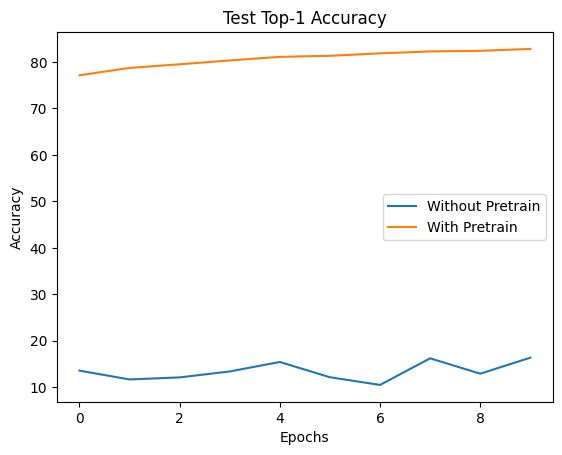

In [52]:
import matplotlib.pyplot as plt

plt.plot(no_pretrain_results['test_acc@1'], label="Without Pretrain")
plt.plot(pretrain_results['test_acc@1'], label="With Pretrain")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Top-1 Accuracy')
plt.legend()
plt.show()